In [8]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt

# NLP libs
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# sentiment + language
from textblob import TextBlob


In [27]:
nltk.download('punkt')       # tokenizers
nltk.download('stopwords')   # stopword list
nltk.download('wordnet')     # lemmatizer
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /home1/10208/takazawaizack/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home1/10208/takazawaizack/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home1/10208/takazawaizack/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home1/10208/takazawaizack/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [26]:
df = pd.read_csv('keywords2.csv')

In [16]:
print(df.columns.tolist())


['Comment', 'Description', 'Keyword', 'Year', 'Upvotes']


In [17]:
# Clean column names
df.columns = [c.strip() for c in df.columns]

# Fix numeric types
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
df['Upvotes'] = pd.to_numeric(df['Upvotes'], errors='coerce').fillna(0).astype(int)

# Combine comment + description
df['Description'] = df['Description'].fillna('')
df['text_raw'] = (df['Comment'].astype(str) + ". " + df['Description'].astype(str)).str.strip()


In [18]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [21]:
# Check if langdetect is available
try:
    from langdetect import detect
    LANGDETECT_OK = True
except ImportError:
    LANGDETECT_OK = False


In [22]:
def detect_lang(text):
    if LANGDETECT_OK:
        try:
            return detect(text)
        except:
            return 'unknown'
    else:
        # heuristic: English if many English stopwords
        tokens = [t.lower() for t in word_tokenize(text)]
        if len(tokens) == 0:
            return 'unknown'
        sw = sum(1 for t in tokens if t in stop_words)
        return 'en' if sw / len(tokens) > 0.12 else 'unknown'

df['lang'] = df['text_raw'].apply(detect_lang)
df['is_english'] = df['lang'].str.startswith('en')


In [23]:
# 4. Sentiment Analysis
# -------------------------------------------
def tb_sentiment(text):
    try:
        s = TextBlob(text).sentiment
        return s.polarity, s.subjectivity
    except:
        return None, None

pols = []
subs = []

for en, t in zip(df['is_english'], df['text_raw']):
    if en:
        p, s = tb_sentiment(t)
    else:
        p, s = (None, None)
    pols.append(p)
    subs.append(s)

df['polarity'] = pols
df['subjectivity'] = subs


In [29]:
# --- quick debug: show columns
print("Columns:", df.columns.tolist())
print("'text_raw' in df.columns ->", 'text_raw' in df.columns)

# --- ensure imports (run once)
import re
import pandas as pd

# If using NLTK for tokenization/lemmatizer/stopwords:
try:
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
except Exception as e:
    raise RuntimeError("Ensure NLTK is installed and resources downloaded (punkt, stopwords, wordnet).") from e

# Ensure NLTK resources (only run if you need to download; comment-out after installed)
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# --- create text_raw if missing
if 'text_raw' not in df.columns:
    # If your original text fields are Comment and Description:
    comment_col = df.get('Comment', pd.Series('', index=df.index))
    desc_col = df.get('Description', pd.Series('', index=df.index))

    # If neither exists, create empty text_raw so next steps don't crash
    if comment_col.isnull().all() and desc_col.isnull().all():
        df['text_raw'] = ''
    else:
        df['text_raw'] = (comment_col.fillna('').astype(str) + '. ' + desc_col.fillna('').astype(str)).str.strip()

# verify it exists now
assert 'text_raw' in df.columns, "text_raw still missing after attempted creation."

# --- robust clean_text
def clean_text(text):
    # guard against non-string inputs
    if not isinstance(text, str):
        # convert numbers to str, treat NaN/None as empty string
        try:
            text = str(text)
        except Exception:
            return ""
    text = text.lower()
    # keep letters, numbers, apostrophes, whitespace
    text = re.sub(r"[^a-z0-9'\s]", " ", text)
    # tokenize — if word_tokenize fails, use a simple split fallback
    try:
        tokens = word_tokenize(text)
    except Exception:
        tokens = text.split()
    # filter stopwords and tiny tokens
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # lemmatize safely
    try:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    except Exception:
        pass
    return " ".join(tokens)

# --- apply (use tqdm for progress if many rows)
try:
    from tqdm.auto import tqdm
    tqdm.pandas()
    df['cleaned_text'] = df['text_raw'].progress_apply(clean_text)
except Exception:
    df['cleaned_text'] = df['text_raw'].apply(clean_text)

# quick check
print(df[['text_raw', 'cleaned_text']].head(5))


Columns: ['Comment', 'Description', 'Keyword', 'Year', 'Upvotes']
'text_raw' in df.columns -> False


  0%|          | 0/78 [00:00<?, ?it/s]

                                            text_raw  \
0  todays vog is insane. You can smell it, feel i...   
1  tricks for dealing with vog. I don’t have asth...   
2                           goodbye vog. goodbye vog   
3  what will actually help with vog. Throat is no...   
4               statewide vog map. statewide vog map   

                                        cleaned_text  
0  today vog insane smell feel throat clearly see...  
1  trick dealing vog asthma anything vog get bad ...  
2                            goodbye vog goodbye vog  
3  actually help vog throat happy right thinking ...  
4                statewide vog map statewide vog map  


In [31]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text) if not pd.isna(text) else ""

    text = text.lower()
    text = re.sub(r"[^a-z0-9'\s]", " ", text)

    # simple tokenization (no NLTK)
    tokens = re.findall(r"\b\w+\b", text)

    # stopwords + length filter
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # safe lemmatization (works without punkt)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


In [32]:
df['cleaned_text'] = df['text_raw'].apply(clean_text)


In [33]:
symptom_patterns = {
    'cough': r'\bcough\w*',
    'throat': r'\bthroat\w*',
    'asthma': r'\basthma\w*',
    'sneeze': r'\bsneez\w*',
    'itch': r'\bitch\w*',
    'eyes': r'\beye\w*|\bvision\b',
    'skin': r'\bskin\b|\birritat\w*',
    'mucus': r'\bmucus\b|\bphlegm\w*',
    'headache': r'\bheadach\w*|\bmigraine\w*',
    'breathing': r'\bbreath\w*|\bshortness\b|\bdifficulty breathing\b',
    'congestion': r'\bcongest\w*|\bnasal\b'
}


In [34]:

def extract_symptoms(text):
    hits = []
    for k, pat in symptom_patterns.items():
        if re.search(pat, text, re.I):
            hits.append(k)
    return hits

df['symptoms'] = df['text_raw'].apply(extract_symptoms)
df['symptom_count'] = df['symptoms'].apply(len)

In [36]:
pm25_df = pd.read_feather("pm25_hawaii_all.feather")
so2_df = pd.read_feather("HI_SO2_2015_2025.feather")
pm25_df = pm25_df.rename(columns={"Arithmetic.Mean": "PM25", "Date.Local": "Date"})
so2_df = so2_df.rename(columns={"Arithmetic Mean": "SO2", "Date Local": "Date"})

In [37]:
pm25_df['Date'] = pd.to_datetime(pm25_df['Date']).dt.date
so2_df['Date'] = pd.to_datetime(so2_df['Date']).dt.date


In [38]:
pollution_df = pd.merge(pm25_df, so2_df, on='Date', how='outer')


In [40]:
#display all columns in one row to look clean datasets
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

pollution_df.iloc[5]

State.Code                                                            15
County.Code                                                            1
Site.Num                                                            1006
Parameter.Code                                                     88101
POC_x                                                                  1
Latitude_x                                                     19.717562
Longitude_x                                                   -155.11053
Datum_x                                                            WGS84
Parameter.Name                                  PM2.5 - Local Conditions
Sample.Duration                                                   1 HOUR
Pollutant.Standard                                                      
Date                                                          2015-01-01
Units.of.Measure                             Micrograms/cubic meter (LC)
Event.Type                                         

In [41]:

# -------------------------------------------
# 7. VOG Trends by Year
# -------------------------------------------
df['keyword_norm'] = df['Keyword'].astype(str).str.lower().str.strip()
vog_df = df[df['keyword_norm'] == 'vog']

# --- Clean & prepare dates ---
pollution_df['Date'] = pd.to_datetime(pollution_df['Date'], errors='coerce')

# Extract Year from pollution data
pollution_df['Year'] = pollution_df['Date'].dt.year

# Keep only needed columns
pollution_df_clean = pollution_df[['Date','Year','PM25','SO2','Latitude_x','Longitude_x','Local.Site.Name']]
pollution_df_clean.head()


,Date,Year,PM25,SO2,Latitude_x,Longitude_x,Local.Site.Name
0,2015-01-01,2015,9.764706,5.500000,19.717562,-155.11053,Hilo
1,2015-01-01,2015,9.764706,6.460000,19.717562,-155.11053,Hilo
2,2015-01-01,2015,9.764706,13.956522,19.717562,-155.11053,Hilo
3,2015-01-01,2015,9.764706,15.171429,19.717562,-155.11053,Hilo
4,2015-01-01,2015,9.764706,2.713043,19.717562,-155.11053,Hilo


In [42]:
# Compute yearly mean PM2.5 and SO2
yearly_vog = pollution_df_clean.groupby("Year").agg({
    "PM25": "mean",
    "SO2": "mean"
}).reset_index()

yearly_vog.rename(columns={
    "PM25": "Avg_PM25",
    "SO2": "Avg_SO2"
}, inplace=True)

yearly_vog

,Year,Avg_PM25,Avg_SO2
0,2015,6.611724,8.263979
1,2016,7.077116,10.224031
2,2017,6.051144,8.792298
3,2018,5.793554,7.974073
4,2019,2.788911,1.054268
5,2020,2.916921,1.377484
6,2021,2.996285,1.888633
7,2022,3.682135,1.733733
8,2023,3.307448,1.361435
9,2024,2.921003,1.153630


In [43]:
pollution_df_clean['Vog_Day'] = (
    (pollution_df_clean['PM25'] > 12) |
    (pollution_df_clean['SO2'] > 3)
).astype(int)

vog_days_per_year = pollution_df_clean.groupby("Year")['Vog_Day'].sum().reset_index()
vog_days_per_year.rename(columns={'Vog_Day': 'Vog_Day_Count'}, inplace=True)
vog_days_per_year


/tmp/ipykernel_875601/3269315690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollution_df_clean['Vog_Day'] = (


,Year,Vog_Day_Count
0,2015,125686
1,2016,138695
2,2017,123889
3,2018,92881
4,2019,25785
5,2020,14810
6,2021,59427
7,2022,46657
8,2023,22749
9,2024,10061


In [50]:
# -------------------------------------------
# REBUILD SENTIMENT COLUMNS (guaranteed)
# -------------------------------------------

def tb_sentiment(text):
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return np.nan, np.nan

df['polarity'] = df['text_raw'].apply(lambda t: tb_sentiment(t)[0])
df['subjectivity'] = df['text_raw'].apply(lambda t: tb_sentiment(t)[1])


In [51]:
sentiment_by_year = df.groupby("Year").agg({
    "polarity": "mean",
    "subjectivity": "mean",
    "Upvotes": "sum",
    "symptom_count": "mean"
}).reset_index()

sentiment_by_year.rename(columns={
    "polarity": "Avg_Sentiment",
    "subjectivity": "Avg_Subjectivity",
    "Upvotes": "Total_Upvotes",
    "symptom_count": "Avg_Symptom_Mentions"
}, inplace=True)


In [52]:
combined = yearly_vog \
    .merge(vog_days_per_year, on="Year", how="left") \
    .merge(sentiment_by_year, on="Year", how="left")

combined


,Year,Avg_PM25,Avg_SO2,Vog_Day_Count,Avg_Sentiment,Avg_Subjectivity,Total_Upvotes,Avg_Symptom_Mentions
0,2015,6.611724,8.263979,125686,0.023233,0.348420,86.0,0.125000
1,2016,7.077116,10.224031,138695,0.017143,0.720476,14.0,3.000000
2,2017,6.051144,8.792298,123889,0.036074,0.400725,149.0,1.250000
3,2018,5.793554,7.974073,92881,0.000000,0.000000,429.0,0.000000
4,2019,2.788911,1.054268,25785,0.108190,0.472999,89.0,1.500000
5,2020,2.916921,1.377484,14810,-0.339286,0.471131,268.0,1.000000
6,2021,2.996285,1.888633,59427,0.022556,0.400544,111.0,1.166667
7,2022,3.682135,1.733733,46657,-0.060377,0.550378,908.0,0.785714
8,2023,3.307448,1.361435,22749,0.013254,0.485610,561.0,0.714286
9,2024,2.921003,1.153630,10061,0.043194,0.405278,93.0,0.500000


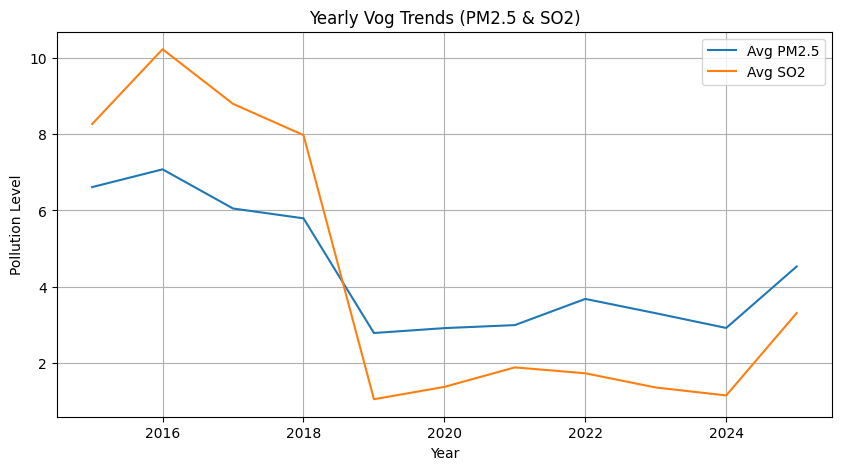

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(combined['Year'], combined['Avg_PM25'], label='Avg PM2.5')
plt.plot(combined['Year'], combined['Avg_SO2'], label='Avg SO2')
plt.xlabel("Year")
plt.ylabel("Pollution Level")
plt.title("Yearly Vog Trends (PM2.5 & SO2)")
plt.legend()
plt.grid(True)
plt.show()


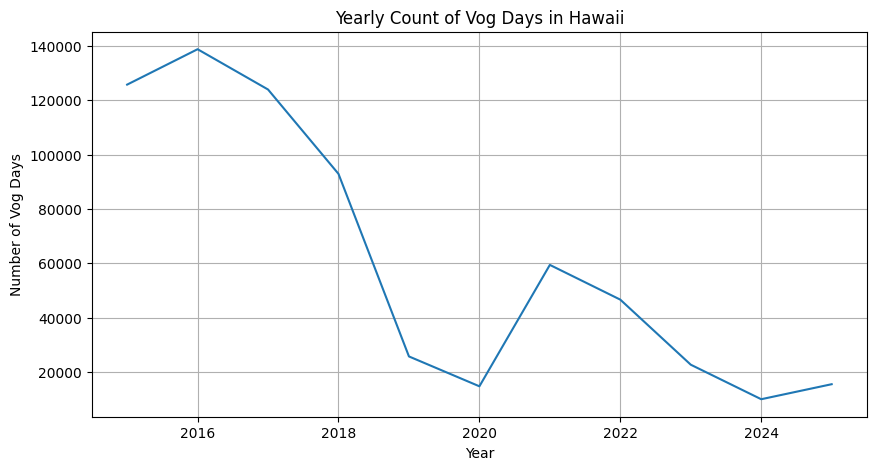

In [54]:
plt.figure(figsize=(10,5))
plt.plot(combined['Year'], combined['Vog_Day_Count'])
plt.xlabel("Year")
plt.ylabel("Number of Vog Days")
plt.title("Yearly Count of Vog Days in Hawaii")
plt.grid(True)
plt.show()


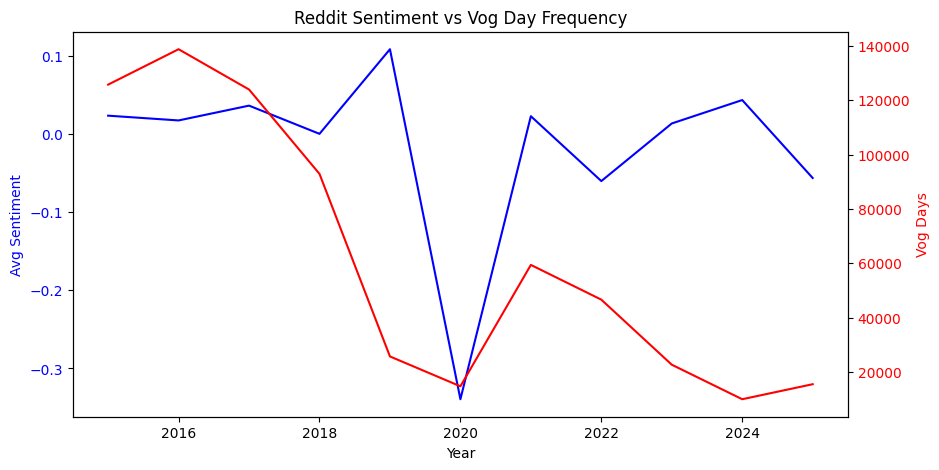

In [55]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel("Year")
ax1.set_ylabel("Avg Sentiment", color="blue")
ax1.plot(combined['Year'], combined['Avg_Sentiment'], color="blue", label="Sentiment")
ax1.tick_params(axis='y', labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Vog Days", color="red")
ax2.plot(combined['Year'], combined['Vog_Day_Count'], color="red", label="Vog Days")
ax2.tick_params(axis='y', labelcolor="red")

plt.title("Reddit Sentiment vs Vog Day Frequency")
plt.show()


In [58]:
if 'Avg_PM25' in df.columns and 'Avg_SO2' in df.columns:
    yearly_bubbles = df.groupby('Year').agg({
        'polarity':'mean',
        'Avg_PM25':'mean',
        'Avg_SO2':'mean',
        'symptom_count':'sum'
    }).reset_index()

    fig = px.scatter(
        yearly_bubbles,
        x="Avg_PM25",
        y="Avg_SO2",
        size="symptom_count",
        color="polarity",
        hover_name="Year",
        title="Vog Conditions vs Sentiment (Bubble = Symptom Reports)",
        labels={"Avg_PM25":"PM2.5", "Avg_SO2":"SO₂", "polarity":"Sentiment"},
        color_continuous_scale="RdBu"
    )

    fig.write_html("vog_sentiment_bubbleplot.html")



/scratch/00713/kelly/miniforge3/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:1438: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/symptom_network.png'

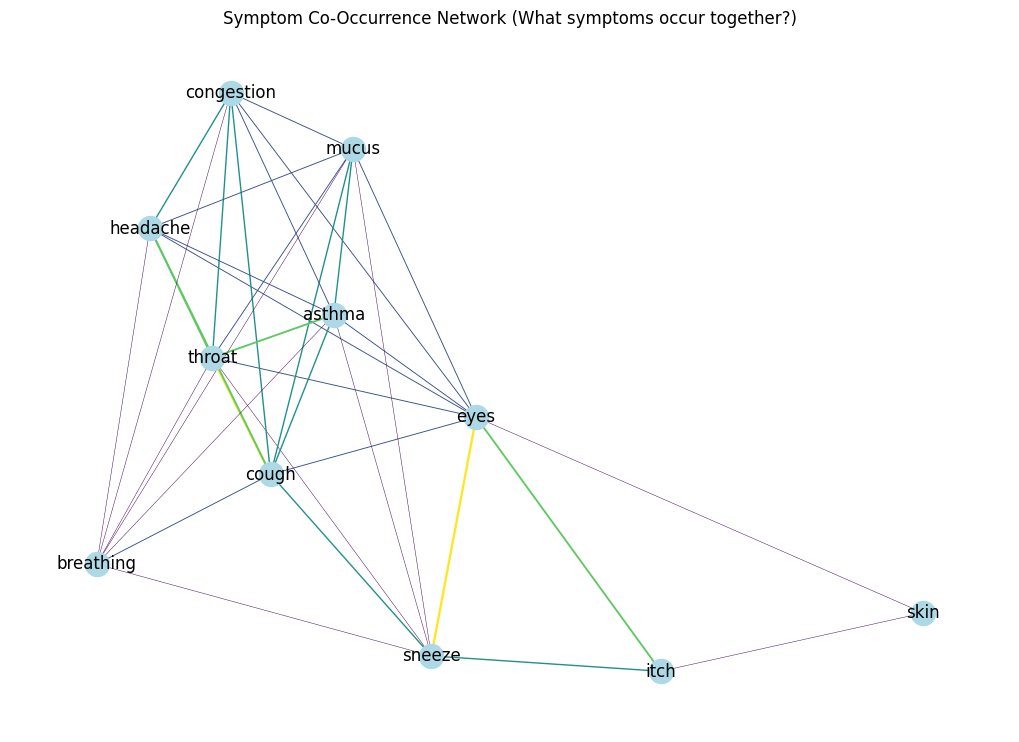

In [64]:
# ------------------------------------------------------------
from itertools import combinations
import networkx as nx

symptom_pairs = []

for symptoms in df['symptoms'].dropna():
    if len(symptoms) >= 2:
        combos = list(combinations(sorted(symptoms), 2))
        symptom_pairs.extend(combos)

# Count pairs
pair_df = pd.DataFrame(symptom_pairs, columns=['sym1','sym2'])
pair_counts = pair_df.value_counts().reset_index(name='count')

# Build graph
G = nx.Graph()

for _, row in pair_counts.iterrows():
    G.add_edge(row['sym1'], row['sym2'], weight=row['count'])

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.8, seed=42)

edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw(G, pos, with_labels=True,
        node_color='lightblue', edge_color=weights,
        width=[w/3 for w in weights], cmap=plt.cm.plasma)

plt.title("Symptom Co-Occurrence Network (What symptoms occur together?)")
plt.savefig("/mnt/data/symptom_network.png", dpi=300)
plt.close()



In [62]:
# 6. Word Importance Over Time (Keyword Trend Lines)
# ------------------------------------------------------------
# Flatten tokens
if 'tokens' in df.columns:
    token_year = df.explode('tokens').dropna(subset=['tokens'])
    top_tokens = (
        token_year.groupby('tokens')
        .size()
        .sort_values(ascending=False)
        .head(8)
        .index.tolist()
    )

    token_trends = token_year[token_year['tokens'].isin(top_tokens)]
    trend_df = token_trends.groupby(['Year','tokens']).size().unstack(fill_value=0)

    trend_df.plot(figsize=(12,6), marker='o')
    plt.title("Top Keyword Trends Over Time")
    plt.xlabel("Year"); plt.ylabel("Frequency")
    plt.legend(title="Keyword")
    plt.tight_layout()
    plt.savefig("keyword_trends.png", dpi=300)
    plt.close()

print("All advanced visualizations saved!")

All advanced visualizations saved!
